# How to Code a Neural Network from Scratch

This notebook demonstrates building a simple neural network from scratch using only **NumPy** for computations and **matplotlib** for visualisations. We will train the network on the **MNIST dataset**, which contains handwritten digits.  

**Key topics covered:**  
- Dataset preparation  
- Activation functions  
- Loss functions  
- Forward and backward propagation  
- Training loop  
- Evaluation and visualisation

We will mathematically explain each component, including the intuition behind activation functions, loss functions, and the weight update rules used in backpropagation.

Structure of a NN

Neuron - holds a called the activation; we standardise this
Weight - how important a connnecttion is
Bias - decides how high the activation needs to be for the neuron to be considered active

*Picture of NN*

Each circle depicts a neuron and each connection between any 2 neurons has a weight and bias attached to it
the first layer is the input layer, this is where all paramaters that you want to take into consideration are inputted; in this case itll be the brightness of each pixel
the final layer is the output layer and this will be the networks final decision; in this case it'll be what number itll be looking at
Anything between them is called the hidden layer

## 1. Setup

We import the required libraries:

- **NumPy** for matrix operations (essential for vectorised computation of forward and backward passes)  
- **matplotlib** for visualising the network’s training progress  
- **dataclasses** to define a structured object for storing images and labels

In [1]:
%pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

## 2. Downloading the Dataset

We use the MNIST dataset containing 28x28 grayscale images of handwritten digits. The dataset is downloaded and extracted.  

Dataset source: [MNIST Numpy](https://www.kaggle.com/datasets/vikramtiwari/mnist-numpy)

In [3]:
!mkdir dataset && curl -L -o dataset/mnist-numpy.zip https://www.kaggle.com/api/v1/datasets/download/vikramtiwari/mnist-numpy && powershell -Command "Expand-Archive -Force dataset/mnist-numpy.zip dataset; Remove-Item dataset/mnist-numpy.zip"

A subdirectory or file dataset already exists.


## 3. Loading and Preprocessing the Dataset

Steps performed:  
- Load training and test images and labels  
- Normalise pixel values to `[0, 1]`  

Training data is used to train the weights and biases of the network and the test data is used to test the performance


In [4]:
class Dataset:
    def __init__(self, images: np.ndarray, labels: np.ndarray):
        self.images, self.labels = Dataset.adjust(images, labels)

    @staticmethod
    def adjust(images, labels):
        return images / 255, np.eye(10)[labels]

def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return Dataset(x_train, y_train), Dataset(x_test, y_test)
    
training, test = load_data('./dataset/mnist.npz')

## 4. Hyperparameters

Define essential hyperparameters for training:  

- **Learning rate**: controls the step size in gradient descent  
- **Epochs**: number of times the entire dataset is passed through the network

In [5]:
learn_rate = 0.015
epochs = 10

## 5. Activation Functions

Activation functions introduce non-linearity to the network. We implement:  

- **Sigmoid**  
- **ReLU**  
- **Tanh**  


In [6]:
# activation functions
def _sigmoid(x, derivative = False):
    if derivative: # d/dx[σ(x)] = σ(x) ⋅ (1 − σ(x))
        s = _sigmoid(x) 
        return s * (1 - s)
    return 1 / (1 + np.exp(-x))

def _relu(x, derivative = False):
    if derivative:
        return (x > 0).astype(float)
    return x * (x > 0)

def _tanh(x, derivative = False):
    if derivative:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

## 6. Loss / Cost Functions

Loss functions measure the network’s prediction error. We implement:  

- **Mean Squared Error** (good for regression tasks)  
- **Cross-Entropy Loss** (suitable for classification)  

We select **cross-entropy loss** for MNIST classification.

In [7]:
def _mean_squared_error(x, y): #better for regression
    return np.mean((x - y) ** 2)

def _cross_entropy_loss(x, y):
    x = np.clip(x, 1e-12, 1.0) # safety in case x = 0 
    return -np.mean(np.sum(y * np.log(x), axis=0))

And now lets choose each function

In [8]:
activation_h = _sigmoid
activation_o = _sigmoid
cost = _cross_entropy_loss

## 7. Network Architecture

A simple fully connected neural network:  

- Input layer: 784 neurons (28x28 flattened image)  
- Hidden layer: 40 neurons  
- Output layer: 10 neurons (digits 0–9)  

Weights and biases are initialised randomly.

In [9]:
"""
w = weights, b = bias, i = input, h = hidden, o = output, l = label
e.g. w_i_h = weights from input layer to hidden layer
"""
input_layer_nodes = 784
hidden_layer_nodes = 40
output_layer_nodes = 10
w_i_h = np.random.uniform(-0.5, 0.5, (hidden_layer_nodes, input_layer_nodes)) #weights for input layer to hidden
w_h_o = np.random.uniform(-0.5, 0.5, (output_layer_nodes, hidden_layer_nodes)) #weights for hidden layer to output
b_i_h = np.zeros((hidden_layer_nodes, 1)) #bias for input layer to hidden
b_h_o = np.zeros((output_layer_nodes, 1)) #bias for output layer to output

## 8. Forward and Backward Propagation

- **Forward propagation**: computes the network output for a given input  
- **Backward propagation**: updates weights and biases using gradient descent  

These functions implement the core of training.

In [ ]:
def forward(image, w_i_h, w_h_o, b_i_h, b_h_o):
    # Forward propagation input -> hidden
    hidden = activation_h(b_i_h + w_i_h @ image)
    # Forward propagation hidden -> output
    output = activation_o(b_h_o + w_h_o @ hidden)
    return output, hidden

def back(difference, hidden, image, w_i_h, w_h_o, b_i_h, b_h_o, learn_rate): #difference = delta_output
    delta_h = w_h_o.T @ difference * activation_h(b_i_h + w_i_h @ image, True)
    # Backpropagation output -> hidden (cost function derivative)
    w_h_o += -learn_rate * difference @ hidden.T
    b_h_o += -learn_rate * difference
    # Backpropagation hidden -> input (activation function derivative)
    w_i_h += -learn_rate * delta_h @ image.T
    b_i_h += -learn_rate * delta_h
    return w_i_h, w_h_o, b_i_h, b_h_o

## 9. Training the Network

Training loop steps:  
1. Shuffle dataset each epoch  
2. Perform forward and backward propagation for each sample  
3. Calculate accuracy and loss  
4. Reduce learning rate every 5 epochs to improve convergence  
5. Track errors and accuracies for plotting

In [11]:
def train(dataset, epochs, learn_rate, w_i_h, w_h_o, b_i_h, b_h_o):
    epoch_errors = []
    epoch_accuracies = []
    n_samples = dataset.images.shape[0]

    for epoch in range(epochs):
        correct = 0
        total_error = 0
        dataset_list = list(zip(dataset.images, dataset.labels))
        shuffle(dataset_list)

        for image, label in dataset_list:
            image = image.reshape(784, 1)
            label = label.reshape(10, 1)

            output, hidden = forward(image, w_i_h, w_h_o, b_i_h, b_h_o)

            error = cost(output, label)
            total_error += error

            correct += int(np.argmax(output) == np.argmax(label))

            w_i_h, w_h_o, b_i_h, b_h_o = back(output - label, hidden, image, w_i_h, w_h_o, b_i_h, b_h_o, learn_rate)

        avg_error = total_error / n_samples
        accuracy = correct / n_samples * 100
        epoch_errors.append(avg_error)
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f}%, Error: {avg_error:.6f}")

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Average Error', color=color)
    ax1.plot(range(1, epochs+1), epoch_errors, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(range(1, epochs+1), epoch_accuracies, marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Training Error and Accuracy Over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    return w_i_h, w_h_o, b_i_h, b_h_o, epoch_errors, epoch_accuracies


## 10. Training Results

We train the network and plot:  

- **Training loss over epochs**  
- **Training accuracy over epochs**  

This helps us visually confirm learning progress.

Epoch 1/10, Accuracy: 88.83%, Error: 0.446807
Epoch 2/10, Accuracy: 93.86%, Error: 0.257115
Epoch 3/10, Accuracy: 95.14%, Error: 0.208205
Epoch 4/10, Accuracy: 95.87%, Error: 0.180082
Epoch 5/10, Accuracy: 96.36%, Error: 0.162129
Epoch 6/10, Accuracy: 96.58%, Error: 0.149283
Epoch 7/10, Accuracy: 96.96%, Error: 0.138667
Epoch 8/10, Accuracy: 97.08%, Error: 0.130638
Epoch 9/10, Accuracy: 97.29%, Error: 0.123767
Epoch 10/10, Accuracy: 97.44%, Error: 0.117536


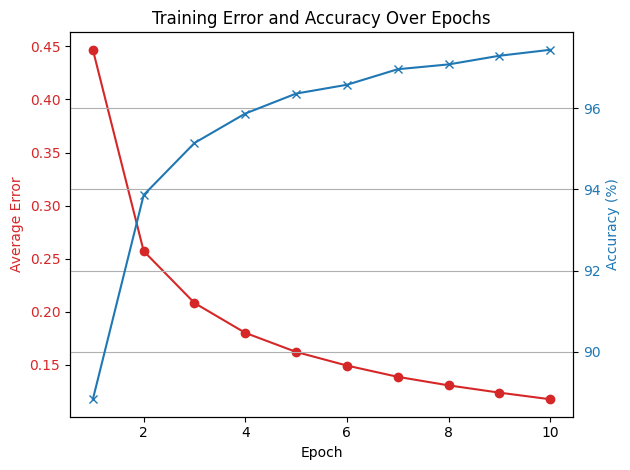

In [12]:
w_i_h, w_h_o, b_i_h, b_h_o, errors, accs = train(training, epochs, learn_rate, w_i_h, w_h_o, b_i_h, b_h_o)

## 11. Testing the Network

We evaluate the trained network on unseen test data and compute accuracy.  

- Count how many predictions match true labels  
- Calculate overall test accuracy

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def collect_misclassified(test_dataset):
    count = 0
    misclassified_indices = []
    for idx, (image, label) in enumerate(zip(test_dataset.images, test_dataset.labels)):
        image, label = image.reshape(784, 1), np.argmax(label)
        output, _ = forward(image, w_i_h, w_h_o, b_i_h, b_h_o)
        pred_label = int(np.argmax(output.flatten()))

        if pred_label != label: misclassified_indices.append(idx)
        else: count += 1
    print(f"{count}/{idx + 1}\t{count/(idx + 1) : .2f}%")
    return misclassified_indices

misclassified = collect_misclassified(test)


9661/10000	 0.97%


## 12. Visualising Predictions

We inspect individual test samples:  

- Display the image  
- Show the network’s predicted label and confidence for each class  
- Helps interpret network behaviour on specific digits

In [14]:
def show_test_sample(test_dataset, idx, w_i_h, w_h_o, b_i_h, b_h_o):
    image = test_dataset.images[idx].reshape(784, 1)
    true_label = np.argmax(test_dataset.labels[idx])

    output, _ = forward(image, w_i_h, w_h_o, b_i_h, b_h_o)
    output = output.flatten()
    pred_label = int(np.argmax(output))

    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(10, 4))
    ax_img.imshow(test_dataset.images[idx].reshape(28, 28), cmap="gray")
    ax_img.set_title(f"True: {true_label}, Pred: {pred_label}")
    ax_img.axis("off")

    ax_bar.bar(range(10), output)
    ax_bar.set_xticks(range(10))
    ax_bar.set_ylim(0, 1)
    ax_bar.set_xlabel("Digit")
    ax_bar.set_ylabel("Confidence")
    ax_bar.set_title("Network Output Confidence")

    plt.tight_layout()
    plt.show()
    
@interact(idx=(0, len(misclassified)-1))
def interactive_view(idx=0):
    show_test_sample(test, misclassified[idx], w_i_h, w_h_o, b_i_h, b_h_o)


interactive(children=(IntSlider(value=0, description='idx', max=338), Output()), _dom_classes=('widget-interac…

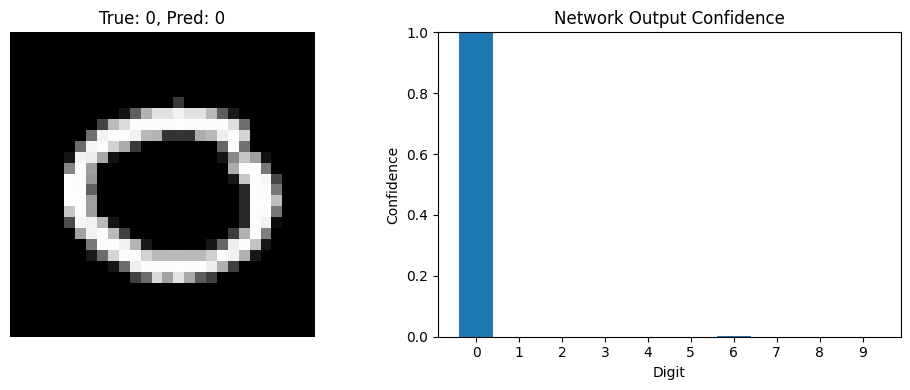

In [19]:
from random import randint
show_test_sample(test, randint(0, test.images.shape[0] - 1), w_i_h, w_h_o, b_i_h, b_h_o)